In [783]:
# Import necessary libraries
import jax.numpy as np
from jax import random, grad, jit, lax
from jax.scipy.linalg import inv, svd, eigh, det
from jax.numpy.linalg import norm
from tqdm import tqdm
from sklearn.datasets import make_spd_matrix
from jax_models import Lorenz96
from jax_models import visualize_observations, Lorenz96, generate_true_states, generate_gc_localization_matrix
#from jax_filters import ensrf_steps
import jax
import matplotlib.pyplot as plt
#from jax_vi import KL_gaussian, log_likelihood


# Parameters
F = 8.0
dt = 0.05
num_steps = 250  # Number of time steps
n_timesteps = num_steps
J0 = 0
n = 40   # Number of state variables
Q = 0.1 * np.eye(n)  # Process noise covariance
R_matrix = 0.1 * np.eye(n)#make_spd_matrix(n)  # Generating a symmetric positive definite matrix for R
R = np.array(R_matrix)  # Observation noise covariance
inv_R = inv(R)
H = np.eye(n)  # Observation matrix


#N = 10
n_ensemble = 10
observation_interval = 1
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state

l96_model = Lorenz96(dt = dt, F = 8)
state_transition_function = l96_model.step
# Generate true states and observations using the Lorenz '96 model
key = random.PRNGKey(0)
observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_model.step, observation_interval)

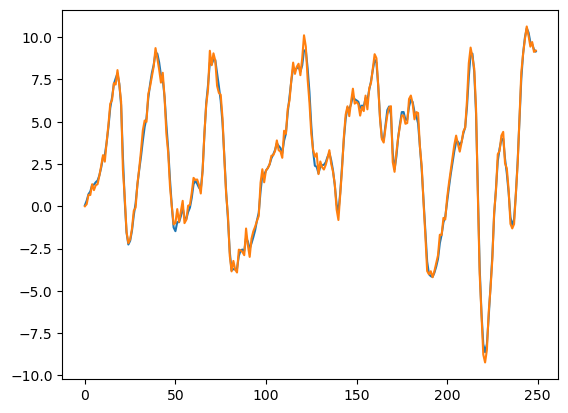

In [784]:
plt.plot(true_states[:, 0])
plt.plot(observations[:, 0])

In [785]:
from jax.lax import scan

def nearest_pd(M):
    eigval, eigvec = np.linalg.eig(M)
    eigval = eigval.at[eigval < 0].set(0)

    return eigvec.dot(np.diag(eigval)).dot(eigvec.T)

@jit
def log_likelihood(v, y, H, inv_R, R, J, J0):
    """
    Computes the log-likelihood of observations given state estimates as a sum.
    Compares this to R, observation noise
    """
    def log_likelihood_j(_, v_y):
        v_j, y_j = v_y
        error = y_j - H @ v_j
        ll = error.T @ inv_R @ error
        return _, ll
    _, lls = lax.scan(log_likelihood_j, None, (v, y))
    sum_ll = np.nansum(lls)
    return -0.5 * sum_ll - 0.5 * (J - J0) * np.log(2 * np.pi) - 0.5 * (J - sum(np.isnan(lls)) - J0) * np.linalg.slogdet(R)[1]


@jit
def KL_gaussian(m1, C1, m2, C2):
    """
    Computes the Kullback-Leibler divergence between two Gaussian distributions.
    m1, C1: Mean and covariance of the first Gaussian distribution.
    m2, C2: Mean and covariance of the second Gaussian distribution.
    n: number of state variables
    """
    C2_inv = inv(C2)
    log_det_ratio = (np.log(np.linalg.eigvals(C2)).sum() - np.log(np.linalg.eigvals(C1)).sum()).real # log(det(C2) / det(C1)), works better with limited precision because the determinant is practically 0
    return 0.5 * (log_det_ratio - n + np.trace(C2_inv @ C1) + ((m2 - m1).T @ C2_inv @ (m2 - m1)))

@jit
def KL_sum(m, C, Q, key):
    """
    Computes the sum of KL divergences between the predicted and updated state distributions.
    Calculates divergence between pairs of predicted and updated state distributions
    
    """
    def KL_j(_, m_C_y):
        m_prev, m_curr, C_prev, C_curr, key = m_C_y
        key, *subkeys_inner = random.split(key, num=N)
        def inner_map(subkey):
            perturbed_state = m_prev + random.multivariate_normal(subkey, np.zeros(n), C_prev)
            m_pred = state_transition_function(perturbed_state)
            return KL_gaussian(m_curr, C_curr, m_pred, Q) 
        mean_kl = np.mean(lax.map(inner_map, np.array(subkeys_inner)), axis=0)
        return _, mean_kl

    _, mean_kls = scan(KL_j, None, (m[:-1, :], m[1:, :], C[:-1, :, :], C[1:, :, :], np.array(random.split(key, num=m.shape[0]-1))))
    kl_sum = sum(mean_kls)
    return kl_sum

In [786]:
@jit
def ensrf_step(ensemble, y, H, Q, R, localization_matrix, inflation, key):
    n_ensemble = ensemble.shape[1]
    x_m = np.mean(ensemble, axis=1)
    ensemble += random.multivariate_normal(key, np.zeros(ensemble.shape[0]), Q, (n_ensemble,)).T
    A = ensemble - x_m.reshape((-1, 1))
    #A = A*inflation
    Pf = inflation*(A @ A.T) / (n_ensemble - 1)
    P = Pf * localization_matrix  # Element-wise multiplication for localization
    K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
    x_m += K @ (y - H @ x_m)
    M = np.eye(x_m.shape[0]) + P @ H.T @ np.linalg.inv(R) @ H
    # U, s, Vh = svd(M)
    # s_inv_sqrt = np.diag(s**-0.5)
    # M_inv_sqrt = U @ s_inv_sqrt @ Vh
    eigenvalues, eigenvectors = eigh(M)
    inv_sqrt_eigenvalues = 1 / np.sqrt(eigenvalues)
    Lambda_inv_sqrt = np.diag(inv_sqrt_eigenvalues)
    M_inv_sqrt = eigenvectors @ Lambda_inv_sqrt @ eigenvectors.T
    updated_ensemble = x_m.reshape((-1, 1)) + M_inv_sqrt @ A
    updated_A = updated_ensemble - np.mean(updated_ensemble, axis=1).reshape((-1, 1))
    updated_P = localization_matrix*(updated_A @ updated_A.T / (n_ensemble - 1))
    return updated_ensemble, updated_P + np.eye(x_m.shape[0])*1e-5  # Now also returning P


@jit
def ensrf_steps(ensemble_init, observations, H, Q, R, localization_matrix, inflation, key):
    """
    Deterministic Ensemble Square Root Filter generalized for any model.
    """
    model_vmap = jax.vmap(lambda v: state_transition_function(v), in_axes=1, out_axes=1)
    key, *subkeys = random.split(key, num=n_timesteps+1)
    subkeys = np.array(subkeys)

    def inner(carry, t):
        ensemble, _ = carry
        ensemble_predicted = model_vmap(ensemble)

        # Update ensemble and covariance based on observation availability
        ensemble_updated, Pf_updated = ensrf_step(ensemble_predicted, observations[t, :], H, Q, R, localization_matrix, inflation, subkeys[t])
        
        #lax.cond(
            # t % observation_interval == 0,
            # lambda _: ensrf_step(ensemble_predicted, observations[t, :], H, Q, R, localization_matrix, inflation),
            # lambda _: (ensemble_predicted, covariances[t-1]),  # Use the last updated covariance
            # None)

        return (ensemble_updated, Pf_updated), (ensemble_updated, Pf_updated)

    # Initialize storage for covariance matrices, including one for the initial state
    covariance_init = np.zeros((n,n))

    # Perform the scan over timesteps with the initial ensemble and covariances
    _, output = jax.lax.scan(inner, (ensemble_init, covariance_init), np.arange(n_timesteps))

    ensembles, covariances = output

    return ensembles, covariances

In [787]:
localization_matrix = np.ones((n, n))#generate_gc_localization_matrix(n, 5)
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
e, c = ensrf_steps(ensemble_init, observations, H, Q, R, localization_matrix, 1.0, key)

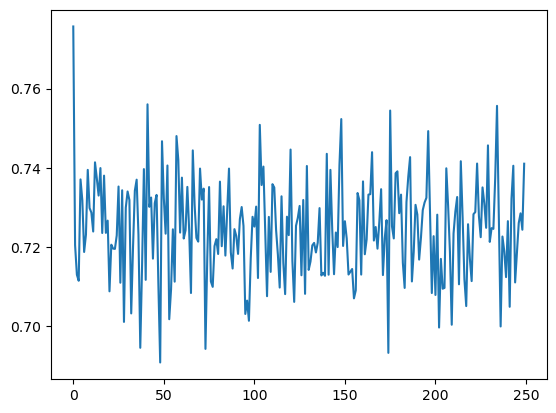

In [788]:
#plt.plot(e.mean(axis=(1,2)))
#plt.plot(true_states.mean(axis=1))
plt.plot([np.trace(cc) for cc in c])

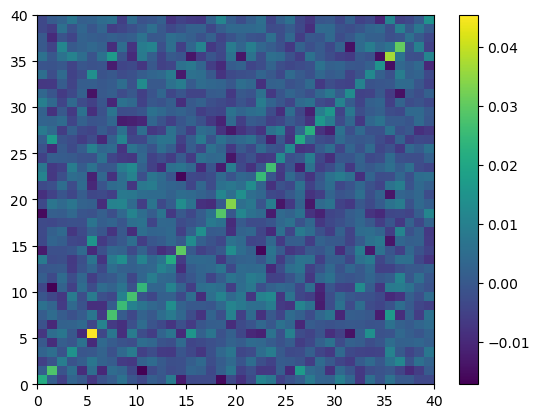

In [789]:
plt.pcolormesh(c[-1])
plt.colorbar()

In [790]:
@jit
def var_cost(inflation, ensemble_init, observations, H, Q, R, localization_matrix, key, J, J0):
   
    states, covariances = ensrf_steps(ensemble_init, observations, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = np.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(ensemble_mean, covariances, Q, key)

    # Calculate log-likelihood values for a batch of perturbed states
    # log_likelihood_vals = lax.map(
    #     lambda subkey: log_likelihood(
    #         random.multivariate_normal(subkey, ensemble_mean[1:], covariances[1, :, :]),
    #         observations, H, np.linalg.inv(R), R, J, J0),
    #     np.array(subkeys))

    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, ensemble_mean, covariances), observations, H, inv_R, R, J, J0)  # Sometimes the covariances are negative definite. Fix
    cost = kl_sum - np.mean(jax.lax.map(inner_map, np.vstack(subkeys)))
    
    return cost

In [767]:
import properscoring

In [795]:
from IPython.display import clear_output
from jax import grad
from tqdm.notebook import tqdm
import jax.numpy as np
from jax import random


# Modification: Use grad to compute the gradient with respect to the inflation parameter
var_cost_grad = grad(var_cost, argnums=0)

inflation_opt = 1.0  # Example starting value for inflation
alpha = 1e-5  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 10  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
localization_matrix = generate_gc_localization_matrix(n, 3)# np.ones((n, n)) # 
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T

crpss = []
inflations = []

for i in tqdm(range(50)):
    key, subkey = random.split(key)
        
    # Gradient descent step for inflation parameter
    grad_inflation = var_cost_grad(inflation_opt, ensemble_init, observations, H, Q, R, localization_matrix, subkey, num_steps, J0)
    inflation_opt -= alpha * grad_inflation  # Update inflation parameter
    
    inflations.append(inflation_opt)

    states, _ = ensrf_steps(ensemble_init, observations, H, Q, R, localization_matrix, inflation_opt, key)
    ensemble_mean = np.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    #rmse = np.sqrt(np.mean((ensemble_mean - true_states)**2))
    crps = properscoring.crps_ensemble(true_states, states).mean(axis=1).mean()
    crpss.append(crps)
    #clear_output(wait=True)
    
    print(inflation_opt, crps)

  0%|          | 0/50 [00:00<?, ?it/s]

1.0122539 0.09318437806959895
1.0248975 0.09426656251813612
1.035442 0.09196034998790362
1.0456921 0.09493321384009255
1.055898 0.09229423544684263
1.0639889 0.09194352931696992
1.0720086 0.09226276834594424
1.0807619 0.09318362867606432
1.0888863 0.09253662923043769
1.0949142 0.0926652676179727
1.1020266 0.09303197959062749
1.1085963 0.09268768022502401
1.1141044 0.09109654010372238
1.1194522 0.09227383281378705
1.1243504 0.09175896889022647
1.1290252 0.0932648780666087
1.1336235 0.0915462960785469
1.138939 0.09239140885966492
1.1434227 0.092143157759232
1.1473223 0.09192963274295604
1.1508633 0.09289224576247693
1.154378 0.09332080600499758
1.1584573 0.0932660558608356
1.1617895 0.0922508756121425
1.1646973 0.09194040861697914
1.1676607 0.09220142532515642
1.1703885 0.0923828892813176
1.1718553 0.09241952375280157
1.1744014 0.09085282539395453
1.1766446 0.09132461176993513
1.1787211 0.09171139215457183
1.1818566 0.09176949054782511
1.1836455 0.09182767584760813
1.1857097 0.0918254386

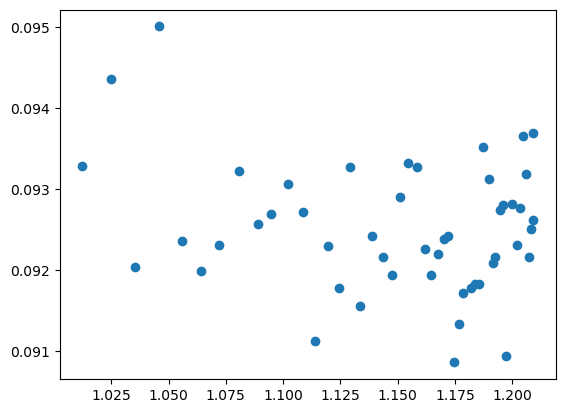

In [796]:
plt.scatter(inflations, rmses)